# Project question 2 - Which driver had the over their career in Formula One?

## 1. Importing data

In [2]:
import pandas as pd
import numpy as np

results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
qualifying = pd.read_csv('qualifying.csv')
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9810,9868,1110,848,3,23,16,2:00.314,\N,\N
9811,9869,1110,855,51,24,17,2:00.832,\N,\N
9812,9870,1110,858,3,2,18,2:01.535,\N,\N
9813,9871,1110,817,213,3,19,2:02.159,\N,\N


## 2. Preparing data

Preparing training data as well as adding useful features such as a ratio of points to teammate. We once again run into the issue of points systems changing over time, so we will normalize by dividing by total points scored in a race.

In [50]:
def get_results(year1, year2=None):
    if year2 is None:
        races_data = races.loc[races['year'] == year1]
    else:
        races_data = races.loc[(races['year'] >= year1) & (races['year'] <= year2)]

    if races_data.empty:
        return pd.DataFrame()  # Return an empty dataframe if no races are found

    races_year_circuit_data = pd.concat([races_data['raceId'], races_data['circuitId'], races_data['time']], axis=1)
    results_data = results.loc[(results['raceId'].isin(races_data['raceId']))]
    results_data = pd.merge(results_data, races_year_circuit_data, on='raceId')
    results_data = results_data.drop(columns=['time_x', 'positionText', 'resultId', 'fastestLap'])
    results_data = results_data.replace('\\N', 0)
    results_data['time_y'] = results_data['time_y'].apply(find_time)
    results_data['fastestLapTime'] = results_data['fastestLapTime'].apply(find_milliseconds)
    # Convert everything to numeric
    results_data = results_data.apply(pd.to_numeric, errors='coerce')

    # Add a column of total points scored in that race by all drivers
    results_data['total_points_race'] = results_data.groupby('raceId')['points'].transform('sum')

    # Add a year column from races.csv
    results_data = pd.merge(results_data, races[['raceId', 'year']], on='raceId')

    return results_data


def get_driver_results(driverId, year1=1950, year2=2023):
    results_data = get_results(year1, year2)

    driver_results = results_data.loc[results_data['driverId'] == driverId].copy()

    all_teammate_results = pd.DataFrame()

    # Loop over all unique constructorIds in driver_results
    for constructorId in driver_results['constructorId'].unique():
        # Get the results for all drivers from the same constructor
        constructor_results = results_data.loc[results_data['constructorId'] == constructorId].copy()

        # Remove the driver's results from constructor_results
        teammate_results = constructor_results.loc[constructor_results['driverId'] != driverId].copy()

        # Only keep the results where the driver and the potential teammate participated in the same race
        teammate_results = teammate_results[teammate_results['raceId'].isin(driver_results['raceId'])]

        # Group by 'raceId' and keep only the teammate with the most points in each race
        teammate_results = teammate_results.loc[teammate_results.groupby('raceId')['points'].idxmax()]

        # Rename the columns in teammate_results
        for column in teammate_results.columns:
            if column != 'raceId':
                teammate_results.rename(columns={column: 'teammate_' + column}, inplace=True)

        all_teammate_results = pd.concat([all_teammate_results, teammate_results])

    # Merge driver_results and all_teammate_results on 'raceId'
    driver_results = pd.merge(driver_results, all_teammate_results, on='raceId', how='left')

    # Calculate the difference in points between the driver and the teammate
    driver_results['points_difference'] = driver_results['points'] - driver_results['teammate_points']

    # Add a column of the difference in points divided by the total points scored in that race
    driver_results['points_difference_ratio'] = driver_results['points_difference'] / driver_results['total_points_race']

    return driver_results

def get_all_driver_results():
    # Get all driver results
    all_driver_results = pd.DataFrame()
    for driverId in drivers['driverId']:
        driver_results = get_driver_results(driverId)
        all_driver_results = pd.concat([all_driver_results, driver_results])
    # Replace all NaN values with 0
    all_driver_results = all_driver_results.fillna(0)
    return all_driver_results

def find_milliseconds(laptime):
    if str(laptime)!='0':
        minutes, seconds_and_ms = str(laptime).split(':')
        seconds, milliseconds = seconds_and_ms.split('.')
        return int(int(minutes) * 60000 + int(seconds) * 1000 + int(milliseconds))
    else:
        return 0

def find_time(time):
    if (time == 0):
        return 0
    hours, minutes, seconds = str(time).split(':')
    return (int(hours) * 100) + int(minutes)

all_results = get_all_driver_results()

## 3. Making the model

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

training_all_results = all_results.drop(columns=['points_difference','points','teammate_points','points_difference_ratio', 'position', 'teammate_position', 'positionOrder', 'teammate_positionOrder'])

X = training_all_results
y = all_results['points_difference_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
print("Mean Squared Error:", mse, "R2 Score:", r2)

Mean Squared Error: 0.0026210781996117987 R2 Score: 0.8528251703075713


In [52]:
predictions = model.predict(training_all_results)

all_results['predicted_points_difference_ratio'] = predictions

# Find the highest predict points difference ratio
all_results.sort_values(by=['predicted_points_difference_ratio'], ascending=False).head(10)

,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,milliseconds,...,teammate_fastestLapTime,teammate_fastestLapSpeed,teammate_statusId,teammate_circuitId,teammate_time_y,teammate_total_points_race,teammate_year,points_difference,points_difference_ratio,predicted_points_difference_ratio
73,722,373,172,18,1,1,1,9.0,53,7854300,...,0.0,0.0,13.0,55.0,0.0,21.0,1963.0,9.0,0.428571,0.394202
81,449,182,1,8,4,1,1,9.0,51,4829065,...,0.0,0.0,5.0,14.0,0.0,22.0,1984.0,9.0,0.409091,0.389391
256,173,30,6,3,1,1,1,10.0,53,5393435,...,0.0,0.0,11.0,22.0,0.0,26.0,2000.0,10.0,0.384615,0.383077
592,452,137,34,5,4,1,1,9.0,63,6507731,...,0.0,0.0,12.0,36.0,0.0,19.0,1983.0,9.0,0.473684,0.381580
248,171,30,6,3,1,1,1,10.0,53,5251638,...,0.0,0.0,4.0,14.0,0.0,26.0,2000.0,10.0,0.384615,0.381292
438,210,49,3,4,2,1,1,10.0,62,5460673,...,0.0,0.0,6.0,21.0,0.0,26.0,1997.0,10.0,0.384615,0.380000
208,157,30,6,1,1,1,1,10.0,53,5253298,...,0.0,0.0,11.0,22.0,0.0,26.0,2001.0,10.0,0.384615,0.378215
184,149,30,6,1,1,1,1,10.0,67,5382724,...,0.0,0.0,20.0,20.0,0.0,26.0,2001.0,10.0,0.384615,0.378215
75,302,95,3,5,1,1,1,10.0,71,5686659,...,0.0,0.0,4.0,27.0,0.0,26.0,1992.0,10.0,0.384615,0.377046
449,215,35,3,3,1,1,1,10.0,59,5281665,...,0.0,0.0,4.0,9.0,0.0,26.0,1997.0,10.0,0.384615,0.376923


The driver who was predicted to dominate their teammate the most at a single race was Jim Clark at the 1963 French Grand Prix, where his teammate failed to finish. 

## Turning race predictions into season predictions
We will take the average of these predictions over a season to see the performance of a driver compared to their teammate

In [53]:
def get_driver_prediction_average(driverId, year):
    driver_results = all_results.loc[(all_results['driverId'] == driverId) & (all_results['year'] == year)]
    return driver_results['predicted_points_difference_ratio'].mean()

# Create an empty dataframe
driver_season_data = pd.DataFrame(columns=['driverId', 'year', 'teammate_driverId', 'average_points_difference_ratio', 'average_predicted_points_difference_ratio'])

# Iterate through every driver's every season
for driverId in drivers['driverId']:
    for year in all_results['year'].unique():
        # Calculate the average points difference ratio and average predicted points difference ratio
        average_points_difference_ratio = all_results.loc[(all_results['driverId'] == driverId) & (all_results['year'] == year)]['points_difference_ratio'].mean()
        average_predicted_points_difference_ratio = get_driver_prediction_average(driverId, year)
        
        # Get the teammate's driverId
        teammate_driverId = all_results.loc[(all_results['driverId'] != driverId) & (all_results['year'] == year)]['driverId'].values[0]
            
        # Append the data to the dataframe
        driver_season_data.loc[len(driver_season_data)] = [driverId, year, teammate_driverId, average_points_difference_ratio, average_predicted_points_difference_ratio]

# Print the dataframe
driver_season_data

,driverId,year,teammate_driverId,average_points_difference_ratio,average_predicted_points_difference_ratio
0,1.0,2008.0,2.0,0.064103,0.058286
1,1.0,2007.0,2.0,0.000000,-0.010643
2,1.0,2009.0,2.0,0.042232,0.039930
3,1.0,2010.0,2.0,0.023450,0.024594
4,1.0,2011.0,2.0,0.015112,0.022769
...,...,...,...,...,...
63413,858.0,1954.0,427.0,NaN,NaN
63414,858.0,1953.0,427.0,NaN,NaN
63415,858.0,1952.0,427.0,NaN,NaN
63416,858.0,1951.0,427.0,NaN,NaN


In [58]:
top_10_seasons = driver_season_data.nlargest(10, 'average_predicted_points_difference_ratio')[['driverId', 'year', 'teammate_driverId', 'average_points_difference_ratio', 'average_predicted_points_difference_ratio']]
top_10_seasons = top_10_seasons.merge(drivers[['driverId', 'forename', 'surname']], left_on='driverId', right_on='driverId')
top_10_seasons = top_10_seasons.merge(drivers[['driverId', 'forename', 'surname']], left_on='teammate_driverId', right_on='driverId')

# Concatenate first and last names into a single column for Driver and Teammate
top_10_seasons['Driver'] = top_10_seasons['forename_x'] + ' ' + top_10_seasons['surname_x']
top_10_seasons['Teammate'] = top_10_seasons['forename_y'] + ' ' + top_10_seasons['surname_y']

# Drop the individual first and last name columns
top_10_seasons = top_10_seasons.drop(['forename_x', 'surname_x', 'forename_y', 'surname_y'], axis=1)

# Reorder the columns
top_10_seasons = top_10_seasons[['Driver', 'year', 'Teammate', 'average_points_difference_ratio', 'average_predicted_points_difference_ratio']]

# Rename the columns
top_10_seasons.columns = ['Driver', 'Year', 'Teammate', 'Avg Points Difference', 'Avg Predicted Points Difference']
top_10_seasons_sorted = top_10_seasons.sort_values(by='Avg Predicted Points Difference', ascending=False)
top_10_seasons_sorted


,Driver,Year,Teammate,Avg Points Difference,Avg Predicted Points Difference
0,Jim Clark,1963.0,Chris Amon,0.294978,0.266970
2,Michael Schumacher,2002.0,Nick Heidfeld,0.228507,0.220236
3,Michael Schumacher,2001.0,Nick Heidfeld,0.216440,0.208355
4,Johnnie Parsons,1950.0,Maurice Trintignant,0.250000,0.206908
7,Johnny Thomson,1959.0,Graham Hill,0.208333,0.204354
1,Jim Clark,1965.0,Chris Amon,0.221053,0.194104
8,Jim Rathmann,1960.0,Graham Hill,0.194444,0.188585
5,Lee Wallard,1951.0,Maurice Trintignant,0.250000,0.177251
9,Jimmy Bryan,1958.0,Graham Hill,0.194444,0.162298
6,Alberto Ascari,1952.0,Maurice Trintignant,0.199653,0.160392


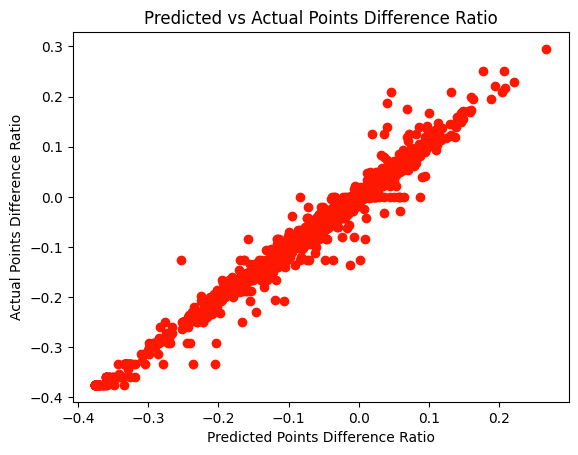

In [57]:
import matplotlib.pyplot as plt

# Create a scatterplot with the specified color
plt.scatter(driver_season_data['average_predicted_points_difference_ratio'], driver_season_data['average_points_difference_ratio'], color='#FF1801')

# Set the labels and title
plt.xlabel('Predicted Points Difference Ratio')
plt.ylabel('Actual Points Difference Ratio')
plt.title('Predicted vs Actual Points Difference Ratio')

plt.savefig('predicted_vs_actual.pdf')
# Show the plot
plt.show()


In [55]:
# Calculate the difference between predicted and actual values
driver_season_data['difference'] = driver_season_data['average_predicted_points_difference_ratio'] - driver_season_data['average_points_difference_ratio']

# Find the biggest upsets
biggest_upsets = driver_season_data.nlargest(10, 'difference')

# Print the biggest upsets
biggest_upsets


,driverId,year,teammate_driverId,average_points_difference_ratio,average_predicted_points_difference_ratio,difference
39141,528.0,1954.0,427.0,-0.333333,-0.204742,0.128592
48761,658.0,1954.0,427.0,-0.125000,0.001151,0.126151
6921,94.0,1984.0,77.0,-0.136364,-0.013200,0.123164
41138,555.0,1955.0,356.0,-0.208333,-0.105883,0.102450
45579,615.0,1954.0,427.0,-0.333333,-0.236008,0.097325
38321,517.0,1960.0,289.0,-0.083333,0.009312,0.092646
44244,597.0,1957.0,347.0,-0.125000,-0.036383,0.088617
48764,658.0,1951.0,427.0,-0.291667,-0.203492,0.088175
38100,514.0,1959.0,289.0,0.000000,0.087021,0.087021
39214,529.0,1955.0,356.0,-0.027778,0.059176,0.086954
